In [37]:
import numpy as np
import cv2 
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from sklearn.decomposition import PCA

In [38]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
config = ConfigProto()
config.allow_soft_placement=True
config.gpu_options.per_process_gpu_memory_fraction=0.7
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


C:\Users\Pomelo Chen\miniconda3\envs\tf2\lib\site-packages\tensorflow\python\client\session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [39]:
#Paper: Deep Descriptor Transforming for Image Co-Localization
#Link : https://arxiv.org/abs/1705.02758

In [40]:
class DDT:
    def __init__(self):
        self.pca = PCA(n_components=1)
        
    def fit(self, data):
        data = data-np.mean(data)
        vgg16 = VGG16(input_shape=data.shape[1:], include_top=False)
        des = vgg16.predict(data) #feature extract
        des = np.reshape(des, (-1,des.shape[-1])) #resize, shape[-1]=channel no.
        self.pca.fit(des)
    
    def transform(self, img):
          
        img = img-np.mean(img)
        vgg16 = VGG16(input_shape=img.shape, include_top=False)
        img = np.reshape(img,(1,img.shape[0],img.shape[1],img.shape[2])) #shape 換成(batch, row, col, chn)
        
        img_feat = vgg16.predict(img)  #換成4個dim才可以丟給vgg16
        img_feat_shape = img_feat.shape   
        img_feat = np.reshape(img_feat, (-1,img_feat_shape[-1]))  #descriptors num, channel
        
        P = self.pca.transform(img_feat)
        P = np.reshape(P, (img_feat_shape[1],img_feat_shape[2])) #shape取前兩個，即原本的row col 
        P = cv2.resize(P, (img.shape[1],img.shape[2]))   #一樣是取row col       
        P = self.normalize(P)        
        
        return P
    
    def jetheatmap(self, P):  #生熱力圖用的
        
        heatmap = np.uint8(255 * P)
        # We use jet colormap to colorize heatmap
        jet = cm.get_cmap("jet")
        # We use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]
        # We create an image with RGB colorized heatmap
        #jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = cv2.resize(jet_heatmap,(heatmap.shape[1], heatmap.shape[0]))

        return jet_heatmap
    
    def predict(self, img): #原圖+熱力圖
        P = self.transform(img)
        heatmap = self.jetheatmap(P)
        superimpose = ((0.5*(heatmap+img))*255).astype('int')
        
        return superimpose
        
    def normalize(self, P):
            L = np.min(P)
            U = np.max(P)
            P = (P-L)/(U-L) #把P的值調整為0～1
            return P

In [41]:
path=r'C:\Users\Pomelo Chen\Desktop\Python\datasets\17flowers\17flower'
def load_data(path):
    filename = os.listdir(path)
    x=[] #img size uniform
    for name in filename:
        x.append(cv2.resize(cv2.imread(path+'\\'+name),(224,224))) #讀取圖片 然後resize
    return np.array(x)/255  #preprocess

In [42]:
train_data = load_data(path)

In [43]:
ddt = DDT()
ddt.fit(train_data)

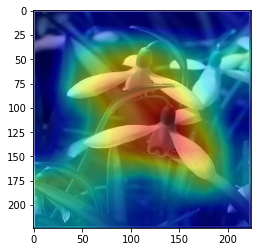

In [44]:
h = ddt.predict(train_data[100])
plt.imshow(h)